In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import tensorflow as tf


from google.colab import drive 

In [2]:
drive.mount('/content/gdrive')
base_path = 'gdrive/My Drive/Colab Notebooks/projects_files/intel_fractal_detection/'

Mounted at /content/gdrive


In [3]:
def generate_df(file_name):
    global base_path
    
    df = pd.read_csv(base_path + file_name)
    df['frac'] = 0
    close = np.array(df['close'])
    frac = np.array(df['frac'])

    df['frac'] = 0
    for i in trange(2, close.shape[0]-2):
        if ((close[i] > close[i-1] and close[i] > close[i-2] and
        close[i] > close[i+1] and close[i] > close[i+2]) or 
        (close[i] < close[i-1] and close[i] < close[i-2] and
        close[i] < close[i+1] and close[i] < close[i+2])):
            frac[i] = 1

    close = np.diff(close)
    frac = frac[1:]

    ts = []
    ts_label = []
    for i in trange(0, close.shape[0] - 50, 10):
        ts.append(close[i:i+50])
        ts_label.append(frac[i:i+50])

    ts = np.array(ts)
    ts_label = np.array(ts_label)

    X_train, X_val, y_train, y_val = train_test_split(ts, ts_label, test_size=0.35, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.40, shuffle=False)

    print('X_train:', X_train.shape)
    print('y_train:', y_train.shape)
    print('X_val', X_val.shape)
    print('y_val', y_val.shape)
    print('X_test', X_test.shape)
    print('y_test', y_test.shape)

    return X_train, y_train, X_val, y_val, X_test, y_test


In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = generate_df('df.csv')

100%|██████████| 2976/2976 [00:00<00:00, 710915.18it/s]

X_train: (1934, 50)
y_train: (1934, 50)
X_val (625, 50)
y_val (625, 50)
X_test (417, 50)
y_test (417, 50)


In [10]:
maximum_epochs = 1000
learning_rate_epochs = 20

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1],1), return_sequences=False, activation='tanh'))
model.add(Dropout(0.15))
model.add(Dense(80, activation='tanh'))
model.add(Dropout(0.15))
model.add(Dense(60, activation='tanh'))
model.add(Dropout(0.15))
model.add(Dense(50, activation='softmax'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
fn =  "model/weights.ckpt" 

# callbacks for early stopping and for learning rate reducer
callbacks_list = [
                  #KerasPruningCallback(trial, 'val_loss'),
                  # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),                     
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='min', min_lr=0.0000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                  monitor='val_loss',mode='min', save_best_only=True)]

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 80)                8080      
                                                                 
 dropout_7 (Dropout)         (None, 80)                0         
                                                                 
 dense_7 (Dense)             (None, 60)                4860      
                                                                 
 dropout_8 (Dropout)         (None, 60)                0         
                                                                 
 dense_8 (Dense)             (None, 50)               

In [6]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],1)

Epoch 1/1000
61/61 - 3s - loss: 0.5858 - accuracy: 0.0083 - val_loss: 0.5413 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 3s/epoch - 47ms/step
Epoch 2/1000
61/61 - 0s - loss: 0.5512 - accuracy: 0.0114 - val_loss: 0.5401 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 375ms/epoch - 6ms/step
Epoch 3/1000
61/61 - 0s - loss: 0.5492 - accuracy: 0.0207 - val_loss: 0.5398 - val_accuracy: 0.0032 - lr: 0.0010 - 386ms/epoch - 6ms/step
Epoch 4/1000
61/61 - 0s - loss: 0.5486 - accuracy: 0.0134 - val_loss: 0.5399 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 342ms/epoch - 6ms/step
Epoch 5/1000
61/61 - 0s - loss: 0.5476 - accuracy: 0.0165 - val_loss: 0.5401 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 355ms/epoch - 6ms/step
Epoch 6/1000
61/61 - 0s - loss: 0.5473 - accuracy: 0.0109 - val_loss: 0.5400 - val_accuracy: 0.0000e+00 - lr: 0.0010 - 358ms/epoch - 6ms/step
Epoch 7/1000
61/61 - 0s - loss: 0.5465 - accuracy: 0.0202 - val_loss: 0.5401 - val_accuracy: 0.0064 - lr: 0.0010 - 343ms/epoch - 6ms/step
Epoch 8/1000
61/

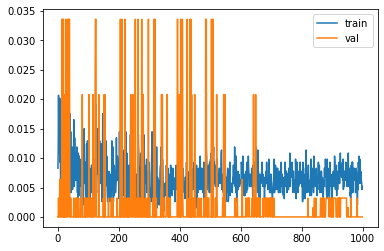

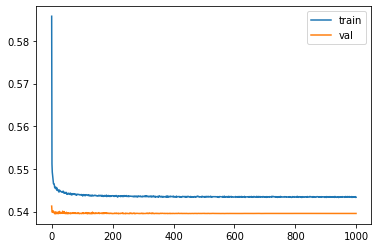

In [11]:
# class_weights = dict(enumerate(class_weights))
history = model.fit(x=X_train, y= y_train,
                  validation_data=(X_val, y_val),
                  # class_weight=class_weights,
                  batch_size=32,
                  epochs=maximum_epochs,
                  shuffle=True, verbose=2,
                  callbacks=callbacks_list)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

model.load_weights(fn)